# Force Computation

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [2]:
def load_data(npoints, folder_path = "D:data OT//",nsegments=1000):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    target_fix=[]
    particle_fix=[]
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = min(int(len(current_df[0])/npoints),nsegments)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        target_fix.append(current_path.split('//')[-1].split('.')[0][:-1])
        particle_fix.append(current_path.split('//')[-1].split('.')[0][-1:])

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return target, np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group),target_fix,particle_fix


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


# Load the data

In [3]:

folder = "D:data OT - TT//TotalData//"
npoints   =  5000
target, x_data, y_data, sum_data, particle_group,target_fix,particle_fix = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

# Equipartition method

In [5]:
#Constants
calibration_factor_x = 1.2523639992636278e-6 #m/V
calibration_factor_y = 1.5930991659754123e-6 #m/V

#boltzmann constant
k_b = 1.38064852*10**(-23) #J K^-1

#absolute temperature = 
T = 295.15 #K

In [6]:
def normalize(xdata,ydata,sumdata):
    """
    Normalize the signals to the sum intensity.
    """
    new_xdata = xdata/sumdata
    new_ydata = ydata/sumdata
    
    return new_xdata, new_ydata

def calibration(xdata,ydata):
    """
    Transforms the intensity data to position data
    """
    new_xdata = xdata * calibration_factor_x
    new_ydata = ydata * calibration_factor_y
    
    return new_xdata, new_ydata

def stiffness(xdata,ydata):
    """
    Computes the stiffness of the trap
    """
    
    kx = k_b*T/np.var(xdata)
    ky = k_b*T/np.var(ydata)
    return kx, ky


In [7]:
particle_label= []
kx_list = []
ky_list = []
for ind in range(0,len(x_data)):
    
    for i in range(0,len(x_data[ind])):
        xdata0 = x_data[ind][i]
        ydata0 = y_data[ind][i]
        sumdata0 = sum_data[ind][i]

        #normalization
        xdata, ydata = normalize(xdata0,ydata0,sumdata0)

        #calibration of the position
        xdata, ydata = calibration(xdata, ydata)

        #stiffness
        kx, ky = stiffness(xdata, ydata)
        kx_list.append(kx)
        ky_list.append(ky)
        #print(target_fix[ind])
        #print("kx = " + str(kx))
        #print("ky = " + str(ky))

        particle_label.append(target_fix[ind])
kx_list = np.array(kx_list)
ky_list = np.array(ky_list)
particle_label = np.array(particle_label)

In [8]:

label0=unique_targets[0]
label1=unique_targets[1]
label2=unique_targets[2]
label3=unique_targets[3]
label4=unique_targets[4]
label5=unique_targets[5]

i0= np.where(particle_label==label0)[0]
i1= np.where(particle_label==label1)[0]
i2= np.where(particle_label==label2)[0]
i3= np.where(particle_label==label3)[0]
i4= np.where(particle_label==label4)[0]
i5= np.where(particle_label==label5)[0]


# Stiffness Plots

<IPython.core.display.Javascript object>


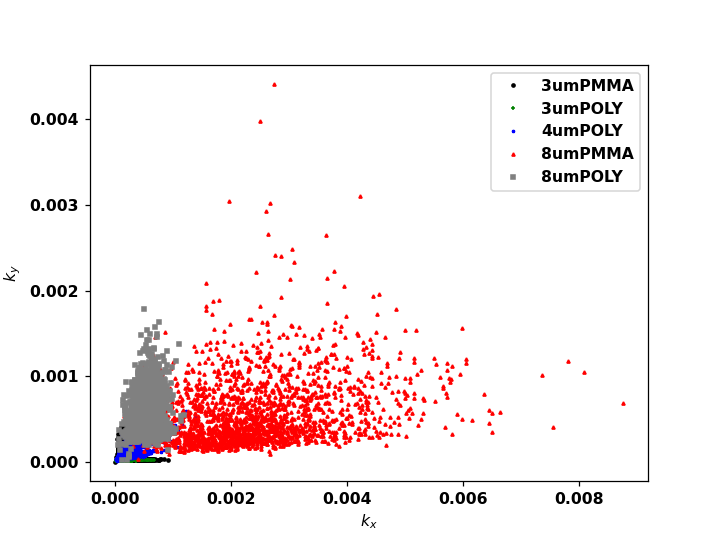

Text(0, 0.5, '$k_y$')

In [9]:
%matplotlib notebook
subplots()
ms=2

s0=0
s1=0
s2=0
s3=0
s4=0
s5=0

plot(kx_list[i0],ky_list[i0],'o',color='k',ms=ms,label=label0)
plot(kx_list[i1],ky_list[i1],'+',color='g',ms=ms,label=label1)
plot(kx_list[i2],ky_list[i2],'*',color='b',ms=ms,label=label2)
plot(kx_list[i3],ky_list[i3],'^',color='r',ms=ms,label=label3)
plot(kx_list[i4],ky_list[i4],'s',color='grey',ms=ms,label=label4)
#plot(kx_list[i5],ky_list[i5],'x',color='y',ms=ms,label=label5)
    
legend()
xlabel("$k_x$")
ylabel("$k_y$")

# Power Spectral Density Method

In [10]:
#Constants

eta = 8.9*10**-4 #Pa

In [11]:
def PSD(xdata, ydata, dt):
    
    freqs, PSD_x = signal.welch(xdata,1/dt)
    freqs, PSD_y = signal.welch(ydata,1/dt)
    
    return PSD_x, PSD_y, freqs


def Lorentzian(freq, gamma, fcorte):       
    f=np.array(freq)                    
    f0X=np.array(fcorte)
    return 1.0/(pi**2*2*gamma*(f**2+f0X**2))

def stiffness_psd(xdata,ydata,dt, Plot=False):
    
    PSD_x, PSD_y, freqs = PSD (xdata,ydata,dt)


    lower_cutoff = 1
    upper_cutoff = -50
    PSD_x=PSD_x[lower_cutoff:upper_cutoff]
    PSD_y=PSD_y[lower_cutoff:upper_cutoff]
    freqs=freqs[lower_cutoff:upper_cutoff]

    popt_x, pcov = curve_fit(Lorentzian, freqs, PSD_x)

    popt_y, pcov = curve_fit(Lorentzian, freqs, PSD_y) 
    
    if Plot:
        subplots()
        subplot(211)
        title("Power Spectral density " + str(target_fix[jj]))

        #plot of the experimental data
        plot(freqs, PSD_x, 'tab:cyan',label='Experimental data')
        plot(freqs, Lorentzian(freqs, *popt_x), 'tab:red',label='Lorentzian fit') #unpack values from popt ("tuple")
        xlabel("Frequency (Hz)")
        ylabel("PSD ($V^2$/Hz)")
        yscale("log") 
        xscale("log")
        axvline(freqs[upper_cutoff],ls=':',color='k')
        axvline(freqs[lower_cutoff],ls=':',color='k')


        subplot(212)
        plot(freqs, PSD_y, 'tab:cyan',label='Experimental data')
        plot(freqs, Lorentzian(freqs, *popt_y), 'tab:red',label='Lorentzian fit') #unpack values from popt ("tuple")
        legend()
        axvline(freqs[upper_cutoff],ls=':',color='k')
        axvline(freqs[lower_cutoff],ls=':',color='k')
        xlabel("Frequency (Hz)")
        ylabel("PSD ($V^2$/Hz)")
        yscale("log") 
        xscale("log")
#####################################################################
    beta,f0X = popt_x
    kx_psd = 2*pi*beta*(k_b*T)*f0X####2*pi... 

    beta,f0Y = popt_y
    ky_psd = 2*pi*beta*(k_b*T)*f0Y

    return kx_psd, ky_psd

<IPython.core.display.Javascript object>


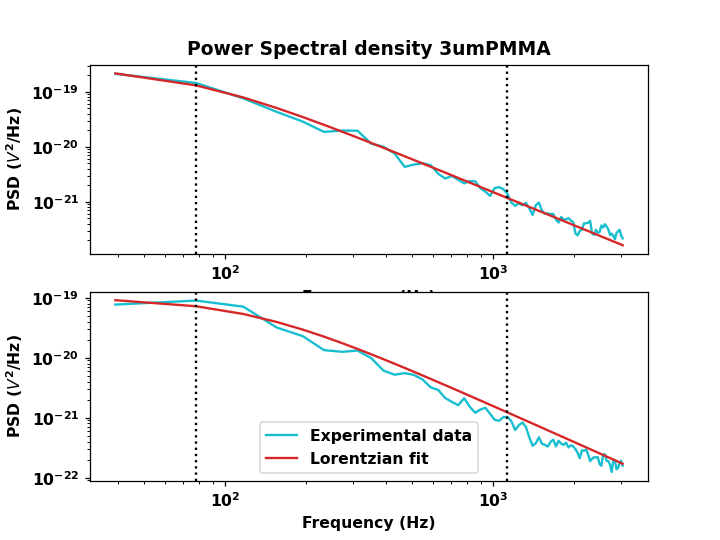

PSD
6.33343921478923e-05
0.0001030375174014752
Equipartition
8.619992577549147e-05
0.00017904325344061738


In [12]:
from scipy.optimize import curve_fit
from scipy import signal


dt=1.0/1e4

jj=3
kk=5
xdata=x_data[jj][kk]
ydata=y_data[jj][kk]
sumdata=sum_data[jj][kk]


xdata, ydata = normalize(xdata,ydata,sumdata)
xdata, ydata = calibration(xdata, ydata)


kx_psd, ky_psd = stiffness_psd(xdata, ydata,dt,Plot=True)
print("PSD")
print(kx_psd)
print(ky_psd)

#stiffness
kx, ky = stiffness(xdata, ydata)
print("Equipartition")
print(kx)
print(ky)


# Compare Both methods and generate table

In [13]:
particle_label= []
particle_number = []
kx_list_psd = []
ky_list_psd = []
kx_list_eq = []
ky_list_eq = []

for ind in range(0,len(x_data)):
    
    kx_list_particle=[]
    ky_list_particle=[]

    for i in range(0,len(x_data[ind])):
        if target_fix[ind] != 'water':
            xdata0 = x_data[ind][i]
            ydata0 = y_data[ind][i]
            sumdata0 = sum_data[ind][i]

            #normalization
            xdata, ydata = normalize(xdata0,ydata0,sumdata0)

            #calibration of the position
            xdata, ydata = calibration(xdata, ydata)

            #stiffness
            kx, ky = stiffness(xdata, ydata)
            kx_list_eq.append(kx)
            ky_list_eq.append(ky)

            kx_psd, ky_psd = stiffness_psd(xdata, ydata,dt)
            kx_list_psd.append(kx_psd)
            ky_list_psd.append(ky_psd)

            particle_label.append(target_fix[ind])
            particle_number.append(particle_fix[ind])


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [14]:
import pandas as pd

d = {"Particle Type": particle_label, "Group": particle_number, 
     "kx_psd": kx_list_psd, "ky_psd": ky_list_psd,
     "kx_eq": kx_list_eq, "ky_eq": ky_list_eq}

df = pd.DataFrame(d)
df

Particle Type Group    kx_psd    ky_psd     kx_eq     ky_eq
0          3umPMMA     1  0.000033  0.000148  0.000069  0.000265
1          3umPMMA     1  0.000041  0.000174  0.000074  0.000302
2          3umPMMA     1  0.000027  0.000118  0.000060  0.000252
3          3umPMMA     1  0.000039  0.000137  0.000076  0.000275
4          3umPMMA     1  0.000041  0.000176  0.000072  0.000299
...            ...   ...       ...       ...       ...       ...
9051       8umPOLY     6  0.000472  0.000626  0.000565  0.000633
9052       8umPOLY     6 -0.000058  0.000229  0.000306  0.000405
9053       8umPOLY     6 -0.000034 -0.000048  0.000313  0.000412
9054       8umPOLY     6  0.000022  0.000313  0.000384  0.000382
9055       8umPOLY     6 -0.000035 -0.000007  0.000302  0.000354

[9056 rows x 6 columns]

In [15]:
#compute the means for each particle
df0 = df.groupby(['Particle Type','Group']).agg(
    {'kx_psd':['mean','std'],'ky_psd':['mean','std'],'kx_eq':['mean','std'],'ky_eq':['mean','std']})

df0

kx_psd              ky_psd                   kx_eq  \
                         mean       std      mean           std      mean   
Particle Type Group                                                         
3umPMMA       1      0.000036  0.000006  0.000095  5.126911e-05  0.000068   
              2      0.000095  0.000012  0.000030  3.510549e-06  0.000151   
              3      0.000255  0.000104  0.000020  5.537198e-06  0.000344   
              4      0.000053  0.000010  0.000088  2.029947e-05  0.000069   
              5      0.000097  0.000012  0.000097  1.281789e-05  0.000128   
              6      0.000122  0.000022  0.000183  2.659765e-05  0.000177   
3umPOLY       1      0.000029  0.000006  0.000009  1.720233e-06  0.000034   
              2      0.000030  0.000005  0.000010  1.207746e-06  0.000036   
              3      0.000013  0.000001  0.000015  2.285237e-06  0.000025   
              4      0.000235  0.000127  0.000011  1.194586e-06  0.000224   
              5      0.000113  0.000072  0.000009  9.988464e-07  0.000129   
              6      0.000077  0.000027  0.000007  6.265727e-07  0.000098   
4umPOLY       1      0.000237  0.000169  0.000092  2.002642e-05  0.000230   
              2      0.000300  0.000312  0.000133  6.520236e-05  0.000253   
              3      0.000242  0.000128  0.000060  1.468953e-05  0.000265   
              4      0.000178  0.000071  0.000040  7.194035e-06  0.000210   
              5      0.000048  0.000013  0.000023  2.811676e-06  0.000049   
              6      0.000042  0.000012  0.000021  3.947543e-06  0.000043   
8umPMMA       1      0.003291  0.001066  0.000938  8.798805e-04  0.002681   
              2      0.003324  0.001495  0.000536  2.572612e-04  0.002397   
              3      0.002949  0.001273  0.000423  2.016367e-04  0.001921   
              4      0.003265  0.001152  0.000347  1.264093e-04  0.002385   
              5      0.004241  0.002169  0.001270  4.073158e-04  0.003017   
              6      0.003266  0.001993  0.001211  4.740032e-04  0.002330   
8umPOLY       1      0.000432  0.000330  0.000586  2.634502e-04  0.000499   
              2      0.000395  0.000442  0.000617  3.061956e-04  0.000477   
              3      0.000557  0.000194  0.000442  1.106175e-04  0.000641   
              4      0.000485  0.000178  0.000610  2.114922e-04  0.000526   
              5      0.000460  0.000896  0.000712  2.826362e-04  0.000502   
              6      0.000535  0.000233  0.000589  1.942892e-04  0.000594   

                                  ky_eq            
                          std      mean       std  
Particle Type Group                                
3umPMMA       1      0.000010  0.000171  0.000089  
              2      0.000029  0.000055  0.000007  
              3      0.000149  0.000037  0.000010  
              4      0.000013  0.000148  0.000035  
              5      0.000023  0.000173  0.000022  
              6      0.000039  0.000326  0.000043  
3umPOLY       1      0.000008  0.000016  0.000003  
              2      0.000007  0.000017  0.000002  
              3      0.000002  0.000024  0.000003  
              4      0.000121  0.000021  0.000002  
              5      0.000084  0.000017  0.000002  
              6      0.000038  0.000013  0.000001  
4umPOLY       1      0.000176  0.000133  0.000044  
              2      0.000304  0.000188  0.000127  
              3      0.000153  0.000085  0.000022  
              4      0.000097  0.000056  0.000011  
              5      0.000015  0.000041  0.000005  
              6      0.000013  0.000037  0.000007  
8umPMMA       1      0.000946  0.000741  0.000627  
              2      0.001173  0.000421  0.000193  
              3      0.000856  0.000336  0.000145  
              4      0.000877  0.000298  0.000102  
              5      0.001409  0.000891  0.000292  
              6      0.001321  0.000880  0.000314  
8umPOLY       1      0.000127  0.000626  0.000285  
              2      0.00

In [16]:
df1 = df.groupby(['Particle Type']).agg(
    {'kx_psd':['mean','std'],'ky_psd':['mean','std'],'kx_eq':['mean','std'],'ky_eq':['mean','std']})

df1

kx_psd              ky_psd               kx_eq            \
                   mean       std      mean       std      mean       std   
Particle Type                                                               
3umPMMA        0.000109  0.000084  0.000086  0.000059  0.000156  0.000113   
3umPOLY        0.000083  0.000097  0.000010  0.000003  0.000091  0.000094   
4umPOLY        0.000174  0.000185  0.000062  0.000049  0.000175  0.000186   
8umPMMA        0.003389  0.001629  0.000788  0.000593  0.002455  0.001166   
8umPOLY        0.000477  0.000455  0.000593  0.000250  0.000540  0.000159   

                  ky_eq            
                   mean       std  
Particle Type                      
3umPMMA        0.000152  0.000104  
3umPOLY        0.000018  0.000004  
4umPOLY        0.000090  0.000078  
8umPMMA        0.000595  0.000412  
8umPOLY        0.000604  0.000223

In [17]:
def clean_graph(ax,lims=None,round_ticks=None):
    """
    Just a function to clean spines for a plot
    """
    if lims!=None:
        ax.set_xlim(lims['x'][0],lims['x'][1])
        ax.set_ylim(lims['y'][0],lims['y'][1])
        if round_ticks != None:
            ax.set_xticks([round(lims['x'][0],round_ticks),round(lims['x'][1],round_ticks)])
            ax.set_yticks([round(lims['y'][0],round_ticks),round(lims['y'][1],round_ticks)])
        else:
            ax.set_xticks([lims['x'][0],lims['x'][1]])
            ax.set_yticks([lims['y'][0],lims['y'][1]])
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    x_left = ax.get_xlim()[0]
    x_right = ax.get_xlim()[-1]
    x_range = x_right-x_left
    factor=0.05
    
    ax.spines['bottom'].set_bounds(x_left,x_right)
    ax.set_xlim(x_left-x_range*factor,x_right+x_range*factor)
    
    y_left = ax.get_ylim()[0]
    y_right = ax.get_ylim()[-1]
    y_range = y_right-y_left
    factor=0.05
    
    ax.spines['left'].set_bounds(y_left,y_right)
    ax.set_ylim(y_left-y_range*factor,y_right+y_range*factor)


# Comparison Plots

## All segments

<IPython.core.display.Javascript object>


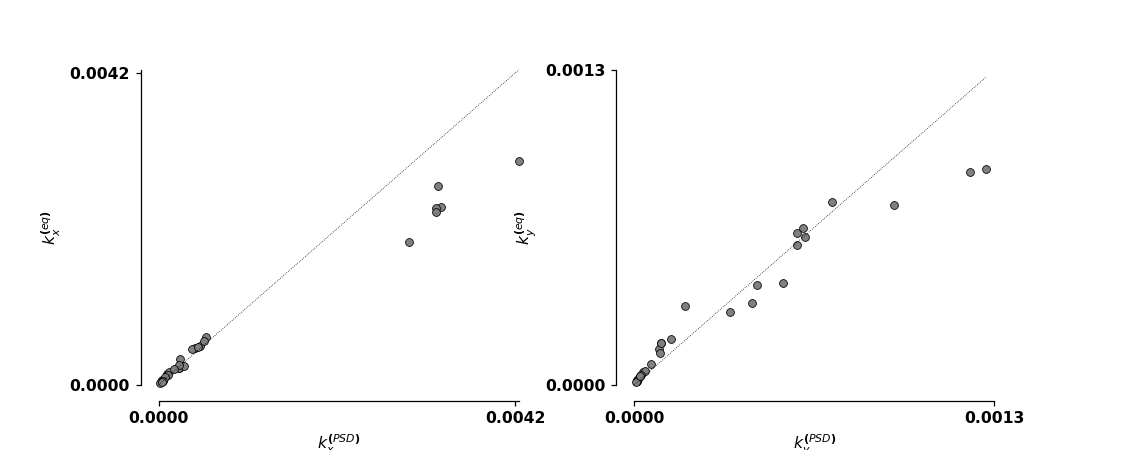

In [32]:
kx_psd_mean = df0['kx_psd']['mean'].to_numpy()
ky_psd_mean = df0['ky_psd']['mean'].to_numpy()
kx_psd_std = df0['kx_psd']['std'].to_numpy()
ky_psd_std = df0['ky_psd']['std'].to_numpy()

kx_eq_mean = df0['kx_eq']['mean'].to_numpy()
ky_eq_mean = df0['ky_eq']['mean'].to_numpy()
kx_eq_std = df0['kx_eq']['std'].to_numpy()
ky_eq_std = df0['ky_eq']['std'].to_numpy()
subplots(figsize=[10,4])
subplot(121)

plot(kx_psd_mean,kx_eq_mean,color='gray',marker='o',
         markeredgecolor='k',markeredgewidth=0.5,ms=5,lw=0)

#errorbar(ky_psd_mean,ky_eq_mean,ky_psd_std,ky_psd_std,color='gray',
#         markeredgecolor='k',markeredgewidth=0.5,ms=5,
#         ecolor='k',fmt='o',elinewidth=0.3,capsize=5)

max_range=np.max([kx_psd_mean,kx_eq_mean])
plot([0,max_range],[0.0,max_range],color='k',ls=':',lw=0.5)
xlabel('$k_x^{(PSD)}$')
ylabel('$k_x^{(eq)}$')

lims = {'x':[0.0, max_range],'y':[0.0, max_range]}
ax=gca()
clean_graph(ax,lims,round_ticks=4)

subplot(122)
max_range=np.max([ky_psd_mean,ky_eq_mean])

plot(ky_psd_mean,ky_eq_mean,color='gray',marker='o',
         markeredgecolor='k',markeredgewidth=0.5,ms=5,lw=0)

#errorbar(ky_psd_mean,ky_eq_mean,ky_psd_std,ky_eq_std,color='gray',
#         markeredgecolor='k',markeredgewidth=0.5,ms=5,
#         ecolor='k',fmt='o',elinewidth=0.3,capsize=5)

plot([0,max_range],[0.0,max_range],color='k',ls=':',lw=0.5)
xlabel('$k_y^{(PSD)}$')
ylabel('$k_y^{(eq)}$')

lims = {'x':[0.0, max_range],'y':[0.0, max_range]}
ax=gca()
clean_graph(ax,lims,round_ticks=4)


## Mean

<IPython.core.display.Javascript object>


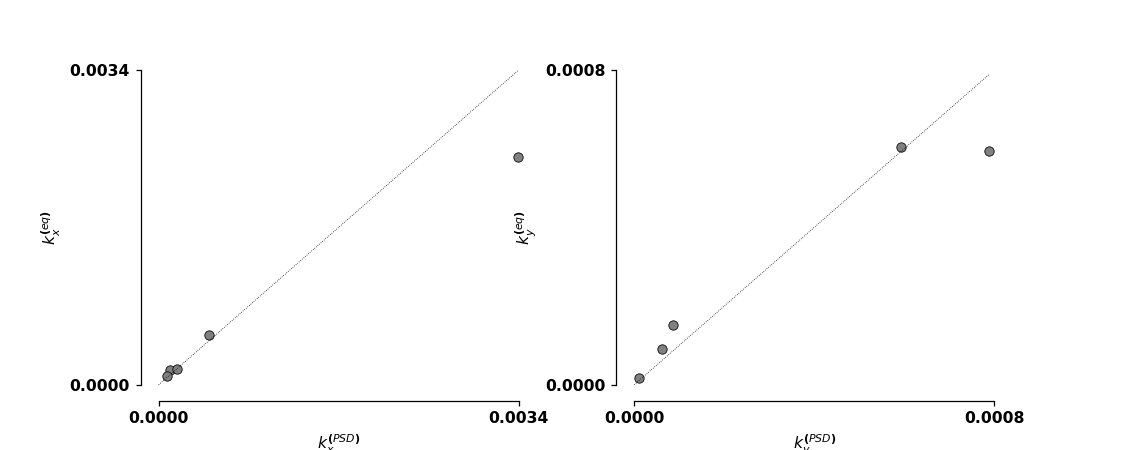

In [33]:
kx_psd_mean = df1['kx_psd']['mean'].to_numpy()
ky_psd_mean = df1['ky_psd']['mean'].to_numpy()
kx_eq_mean = df1['kx_eq']['mean'].to_numpy()
ky_eq_mean = df1['ky_eq']['mean'].to_numpy()
subplots(figsize=[10,4])
subplot(121)

plot(kx_psd_mean,kx_eq_mean,'o',color='gray',markeredgecolor='k',markeredgewidth=0.5)
max_range=np.max([kx_psd_mean,kx_eq_mean])
plot([0,max_range],[0.0,max_range],color='k',ls=':',lw=0.5)
xlabel('$k_x^{(PSD)}$')
ylabel('$k_x^{(eq)}$')

lims = {'x':[0.0, max_range],'y':[0.0, max_range]}
ax=gca()
clean_graph(ax,lims,round_ticks=4)

subplot(122)
max_range=np.max([ky_psd_mean,ky_eq_mean])

plot(ky_psd_mean,ky_eq_mean,'o',color='gray',markeredgecolor='k',markeredgewidth=0.5)
plot([0,max_range],[0.0,max_range],color='k',ls=':',lw=0.5)
xlabel('$k_y^{(PSD)}$')
ylabel('$k_y^{(eq)}$')

lims = {'x':[0.0, max_range],'y':[0.0, max_range]}
ax=gca()
clean_graph(ax,lims,round_ticks=4)